The MIT License (MIT)

Copyright © 2026 Martin Ladecký, Ivana Pultarová, François Bignonnet, Indre Jödicke, Jan Zeman, Lars Pastewka

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction example  - Conductivity
This notebook demonstrates the application of the Jacobi-accelerated FFT-based solver to a 2D steady-state conductivity problem. It compares the performance of three different preconditioners:
1. **Green Preconditioner**: Standard FFT-based preconditioner using a reference homogeneous material.
2. **Jacobi Preconditioner**: A diagonal preconditioner based on the system matrix.
3. **Green-Jacobi Preconditioner**: A hybrid approach combining both Green and Jacobi preconditioning for improved convergence.

## Reference
This notebook accompanies the paper "Jacobi-accelerated FFT-based solver for smooth high-contrast data" and reproduces results similar to Figure 1 in the manuscript (but for scalar problem), demonstrating the effect of smoothing on preconditioner performance. The notebook explores how iterative smoothing of a circle inclusion affects the convergence rate of the Preconditioned Conjugate Gradient (PCG) solver.


In [2]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline


## Utility Functions

In [3]:
def get_shape_function_gradients(discretization_type, pixel_size):
    """
    Returns the shape function gradients and quadrature weights for a single pixel.
    Currently supports 'linear_triangles'.
    """
    if discretization_type == 'linear_triangles':
        ndim = 2
        nb_quad = 2
        dx, dy = pixel_size
        # B(dim, quad_point, node_idx)
        B = np.zeros([ndim, nb_quad, 4])
        # first quad point
        B[:, 0, :] = [[-1 / dx, 0, 1 / dx, 0],
                      [-1 / dy, 1 / dy, 0, 0]]
        # second quad point
        B[:, 1, :] = [[0, -1 / dx, 0, 1 / dx],
                      [0, 0, -1 / dy, 1 / dy]]

        weights = np.array([dx * dy / 2, dx * dy / 2])
        return B.reshape(ndim, nb_quad, 2, 2), weights

def get_gradient_operators(pixel_size, N, dofs_per_node):
    """
    Creates and returns the gradient (B) and weighted divergence (Bw_t) operators
    for the given grid and discretization.
    """
    ndim = 2
    B_dqij, weights = get_shape_function_gradients('linear_triangles', pixel_size)
    nb_quad = weights.size

    def B_op(u_ixy):
        grad_u_ijqxy = np.zeros([dofs_per_node, ndim, nb_quad, *N])
        for pixel_node in np.ndindex(2, 2):
            grad_u_ijqxy += np.einsum('jq,ixy...->ijqxy...',
                                      B_dqij[(..., *pixel_node)],
                                      np.roll(u_ixy, -1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1))),
                                      optimize='optimal')
        return grad_u_ijqxy

    def Bw_t_op(flux_ijqxyz):
        div_flux_ixy = np.zeros([dofs_per_node, *N])
        # apply quadrature weights
        flux_weighted = np.einsum('ijq...,q->ijq...', flux_ijqxyz, weights, optimize='optimal')
        for pixel_node in np.ndindex(2, 2):
            div_fnxyz_pixel_node = np.einsum('jq,ijqxy...->ixy...',
                                             B_dqij[(..., *pixel_node)],
                                             flux_weighted, optimize='optimal')
            div_flux_ixy += np.roll(div_fnxyz_pixel_node, 1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1)))
        return div_flux_ixy

    return B_op, Bw_t_op, weights

def solve_sparse(A, b, M=None):
    """
    A simple wrapper around scipy's Conjugate Gradient solver that also counts iterations.
    """
    num_iters = 0
    def callback(xk):
        nonlocal num_iters
        num_iters += 1
    x, status = sc.sparse.linalg.cg(A, b, M=M, atol=1e-6, maxiter=10000, callback=callback)
    return x, status, num_iters

def apply_smoother_log10(phase):
    """
    Applies a Gaussian-like smoothing filter to the material phase field in log10 space.
    This helps to smooth out sharp interfaces.
    """
    kernel = np.array([[0.0625, 0.125, 0.0625],
                       [0.125, 0.25, 0.125],
                       [0.0625, 0.125, 0.0625]])
    # Apply convolution for smoothing (assuming phase is at least 3D [quad, x, y])
    smoothed_arr = sc.signal.convolve2d(np.log10(phase[0]), kernel, mode='same', boundary='wrap')
    # Fix boundaries
    smoothed_arr[0, :] = 0
    smoothed_arr[-1, :] = 0
    smoothed_arr[:, 0] = 0
    smoothed_arr[:, -1] = 0
    return 10 ** smoothed_arr


## Problem Parameters


In [4]:
# Problem Parameters
# ------------------
nb_quad_points_per_pixel = 2
ndim = 2
N_x = N_y = 64  # Number of voxels in each direction
N = (N_x, N_y)
delta_x, delta_y = 1 / N_x, 1 / N_y
pixel_size = (delta_x, delta_y)
domain_vol = (delta_x * N_x) * (delta_y * N_y)

# Degrees of freedom configuration
n_u_dofs = 1  # 1 for scalar field (conductivity)
ndof = n_u_dofs * np.prod(np.array(N))
temp_shape = (n_u_dofs,) + N
grad_shape = (n_u_dofs, ndim, nb_quad_points_per_pixel) + N

# Basic FFT operators and tensor dot products
dot21 = lambda A, v: np.einsum('ij...,fj...  ->fi...', A, v)
fft = lambda x: np.fft.fftn(x, [*N])
ifft = lambda x: np.fft.ifftn(x, [*N])

# Initialize gradient operators
B, Bw_t, quadrature_weights = get_gradient_operators(pixel_size, N, n_u_dofs)


## Problem Definition


In [5]:
# Problem Definition
# ------------------
mat_contrast = 1.
inc_contrast = 1e-4

# Initial phase distribution: Square inclusion in the center
phase = np.ones([nb_quad_points_per_pixel, N_x, N_y])
phase[:, phase.shape[1] * 1 // 4 + 1:phase.shape[1] * 3 // 4 + 1,
      phase.shape[2] * 1 // 4 + 1:phase.shape[2] * 3 // 4 + 1] *= inc_contrast

nb_of_filters = 100
nb_it_G_wrt_filter = []
nb_it_GJ_wrt_filter= []
nb_it_J_wrt_filter=[]


## Main Loop


In [6]:
for aplication in np.arange(nb_of_filters):
    # Apply smoothing iteratively to test how it affects convergence
    if aplication != 0:
        for apply in np.arange(10):
            smoothed = apply_smoother_log10(phase)
            phase[0] = smoothed
            phase[1] = smoothed

    # Update material data with smoothed phase field
    A2_0 = mat_contrast * np.eye(ndim)
    mat_data_ijqxy = np.einsum('ij,qxy', A2_0, phase)

    # Macroscopic loading
    macro_grad_ij = np.zeros([1, ndim])
    macro_grad_ij[0, 0] = 1
    E_ijqxy = np.zeros(grad_shape)
    E_ijqxy += macro_grad_ij[(slice(None), slice(None)) + (np.newaxis,) * (len(E_ijqxy.shape) - 2)]

    # Define system matrix operator K(u) and RHS vector b
    K_fun_I = lambda x: Bw_t(
        dot21(mat_data_ijqxy,
              B(u_ixy=x.reshape(temp_shape)))).reshape(-1)
    b_I = -Bw_t(dot21(mat_data_ijqxy, E_ijqxy)).reshape(-1)

    # --- Preconditioners ---
    
    # 1. Green's Preconditioner (Standard FFT-based)
    ref_mat_data_ij = np.array([[1, 0], [0, 1]])
    K_ref_fun = lambda x: Bw_t(dot21(ref_mat_data_ij, B(u_ixy=x.reshape(temp_shape))))

    G_diag_ixy = np.zeros([n_u_dofs, n_u_dofs, *N])
    for d in range(n_u_dofs):
        unit_impuls_ixy = np.zeros(temp_shape)
        unit_impuls_ixy[(d,) + ndim * (0,)] = 1
        G_diag_ixy[:, d, ...] = K_ref_fun(x=unit_impuls_ixy)

    G_diag_ixy = np.real(fft(x=G_diag_ixy))
    G_diag_ixy[G_diag_ixy != 0] = 1 / G_diag_ixy[G_diag_ixy != 0]
    Green_fun = lambda x: np.real(ifft(G_diag_ixy * fft(x=x.reshape(temp_shape)))).reshape(-1)

    # 2. Jacobi Preconditioner (Diagonal of the system matrix)
    J_diag_ixy = np.zeros([n_u_dofs, *N])
    for x_i in range(2):
        for y_i in range(2):
            comb_impuls_ixy = np.zeros(temp_shape)
            comb_impuls_ixy[0, x_i::2, y_i::2] = 1.0
            comb_impuls_ixy = Bw_t(dot21(A=mat_data_ijqxy, v=B(u_ixy=comb_impuls_ixy)))
            J_diag_ixy[0, x_i::2, y_i::2] = np.where(comb_impuls_ixy[0, x_i::2, y_i::2] != 0.,
                                                     1 / np.sqrt(comb_impuls_ixy[0, x_i::2, y_i::2]), 1.)

    Jacobi_fun = lambda x: J_diag_ixy * J_diag_ixy * x.reshape(temp_shape)
    
    # 3. Green-Jacobi Preconditioner (Hybrid)
    GreenJacobi_fun = lambda x: (J_diag_ixy * Green_fun(J_diag_ixy * x.reshape(temp_shape)).reshape(temp_shape))

    # --- Solve and store iteration counts ---
    
    # Solve with Green Preconditioner
    _, _, n_G = solve_sparse(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, sp.LinearOperator((ndof, ndof), Green_fun))
    nb_it_G_wrt_filter.append(n_G)

    # Solve with Jacobi Preconditioner
    _, _, n_J = solve_sparse(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, sp.LinearOperator((ndof, ndof), Jacobi_fun))
    nb_it_J_wrt_filter.append(n_J)

    # Solve with Green-Jacobi Preconditioner
    _, _, n_GJ = solve_sparse(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, sp.LinearOperator((ndof, ndof), GreenJacobi_fun))
    nb_it_GJ_wrt_filter.append(n_GJ)

    print(f'Filter {aplication}: Green={n_G}, Jacobi={n_J}, Green-Jacobi={n_GJ}')


Filter 0: Green=6, Jacobi=94, Green-Jacobi=24
Filter 1: Green=223, Jacobi=97, Green-Jacobi=15
Filter 2: Green=291, Jacobi=89, Green-Jacobi=14
Filter 3: Green=309, Jacobi=85, Green-Jacobi=14
Filter 4: Green=335, Jacobi=86, Green-Jacobi=13
Filter 5: Green=335, Jacobi=106, Green-Jacobi=12
Filter 6: Green=344, Jacobi=116, Green-Jacobi=12
Filter 7: Green=333, Jacobi=115, Green-Jacobi=14
Filter 8: Green=325, Jacobi=117, Green-Jacobi=14
Filter 9: Green=315, Jacobi=119, Green-Jacobi=13
Filter 10: Green=301, Jacobi=128, Green-Jacobi=13
Filter 11: Green=281, Jacobi=131, Green-Jacobi=13
Filter 12: Green=268, Jacobi=132, Green-Jacobi=13
Filter 13: Green=252, Jacobi=134, Green-Jacobi=12
Filter 14: Green=238, Jacobi=134, Green-Jacobi=12
Filter 15: Green=222, Jacobi=134, Green-Jacobi=12
Filter 16: Green=211, Jacobi=134, Green-Jacobi=12
Filter 17: Green=197, Jacobi=132, Green-Jacobi=13
Filter 18: Green=185, Jacobi=132, Green-Jacobi=13
Filter 19: Green=175, Jacobi=131, Green-Jacobi=13
Filter 20: Green=

## Plot Results


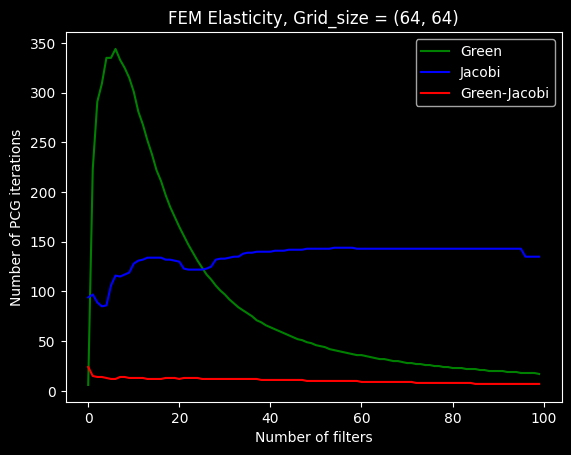

In [8]:
plt.figure()
plt.plot(nb_it_G_wrt_filter, label='Green',color='g')
plt.plot(nb_it_J_wrt_filter, label='Jacobi',color='b')
plt.plot(nb_it_GJ_wrt_filter, label='Green-Jacobi',color='r')
plt.title(f'FEM Elasticity, Grid_size = {N}')
plt.xlabel('Number of filters')
plt.ylabel('Number of PCG iterations')
plt.legend()
plt.savefig('../figures/introduction_conductivity_iterations.png')
plt.show()
